In [24]:
# Import Library

import pandas as pd                                   # Pandas for data manipulation
import numpy as np                                    # Numpy for array and basic math operation
import matplotlib.pyplot as plt                       # Matplotlib for plotting
import seaborn as sns                                 # Seaborn for plotting
from sklearn.cluster import KMeans                    # Sklearn for KMeans clustering
from yellowbrick.cluster import SilhouetteVisualizer  # Yellowbrick for silhouete score visualizer
import warnings                                       # Warnings to remove warning
warnings.filterwarnings('ignore')

In [25]:
# Import transaction data

df = pd.read_csv("Case Study - Transaction.csv",sep=";")
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [26]:
# Group by Date and aggregate TrabsactionID count, Qty sum, and TotalAmount sum

df_agg = df.groupby('CustomerID').agg({"TransactionID":"count",
                                      "Qty":"sum",
                                      "TotalAmount":"sum"}).reset_index()
df_agg

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [27]:
# Import customer data

df_cust = pd.read_csv("Case Study - Customer - Edited.csv",sep=";")
df_cust

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57
...,...,...,...,...,...
442,443,33,1,NaN,9.28
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81


In [28]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [29]:
# Merge transaction and customer data

df_merge = pd.merge(df_agg,df_cust,on="CustomerID")
df_merge.columns = [c.replace(' ', '_') for c in df_merge.columns]
df_merge

,CustomerID,TransactionID,Qty,TotalAmount,Age,Gender,Marital_Status,Income
0,1,17,60,623300,55,1,Married,5.12
1,2,13,57,392300,60,1,Married,6.23
2,3,15,56,446200,32,1,Married,9.17
3,4,10,46,302500,31,1,Married,4.87
4,5,7,27,268600,58,1,Married,3.57
...,...,...,...,...,...,...,...,...
442,443,16,59,485100,33,1,NaN,9.28
443,444,18,62,577700,53,0,Married,15.31
444,445,18,68,587200,51,0,Married,14.48
445,446,11,42,423300,57,0,Married,7.81


In [30]:
# Data cleaning and wrangling

df_merge = df_merge.dropna().reset_index(drop=True)
df_merge["Marital_Status"].replace(["Married","Single"],[1,0],inplace=True)
df_merge

,CustomerID,TransactionID,Qty,TotalAmount,Age,Gender,Marital_Status,Income
0,1,17,60,623300,55,1,1,5.12
1,2,13,57,392300,60,1,1,6.23
2,3,15,56,446200,32,1,1,9.17
3,4,10,46,302500,31,1,1,4.87
4,5,7,27,268600,58,1,1,3.57
...,...,...,...,...,...,...,...,...
439,442,13,37,269400,42,1,1,14.88
440,444,18,62,577700,53,0,1,15.31
441,445,18,68,587200,51,0,1,14.48
442,446,11,42,423300,57,0,1,7.81


['Qty', 'TotalAmount', 'Income', 'Age']


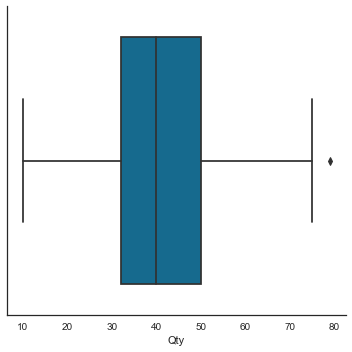

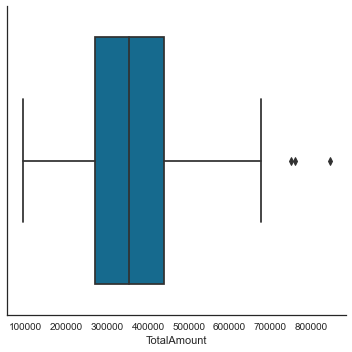

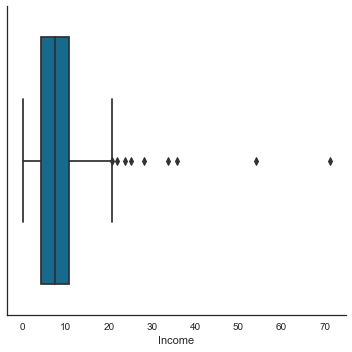

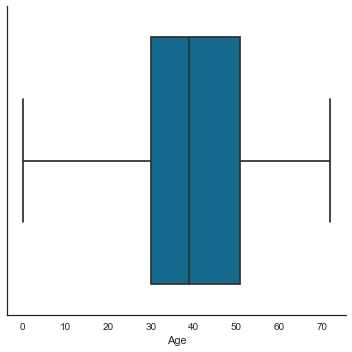

In [31]:
# Detecting outliers with boxplot

columns_name = list(["Qty","TotalAmount","Income","Age"])
print(columns_name)

for i in columns_name :
  sns.catplot(data=df_merge,x=i, kind="box")
plt.show()

In [32]:
# Find 25% and 75% limit

df_d = df_merge[["Qty","TotalAmount","Income","Age"]].describe()
df_d_t = df_d.transpose()
df_q = pd.DataFrame(df_d_t, columns=["25%","75%"])
df_q_t = df_q.transpose()
df_q_t

,Qty,TotalAmount,Income,Age
25%,32.0,270675.0,4.210,30.0
75%,50.0,439750.0,10.845,51.0


In [33]:
# Filter data to remove outliers

df_f = df_merge.copy()

for i in columns_name:
  q1 = df_q_t.loc["25%",i]
  q3 = df_q_t.loc["75%",i]
  iqr = q3-q1
  lb = q1-(iqr*1.5)
  ub = q3+(iqr*1.5)
  df_f = df_f[(df_f[i] > lb) & (df_f[i] < ub)]

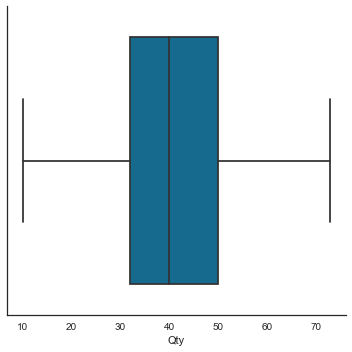

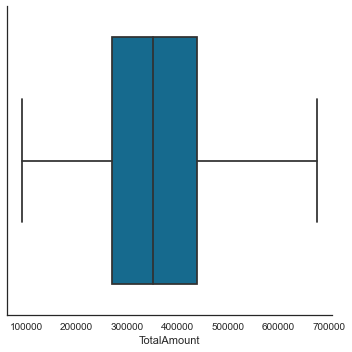

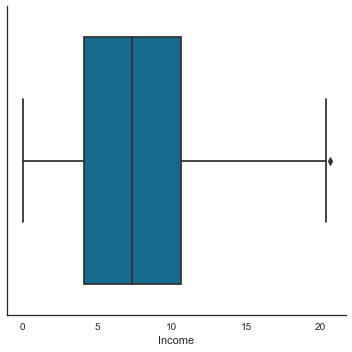

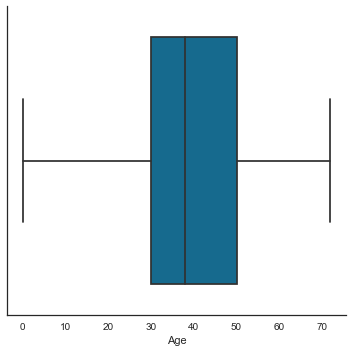

In [34]:
for i in columns_name :
  sns.catplot(data=df_f,x=i, kind="box")
plt.show()

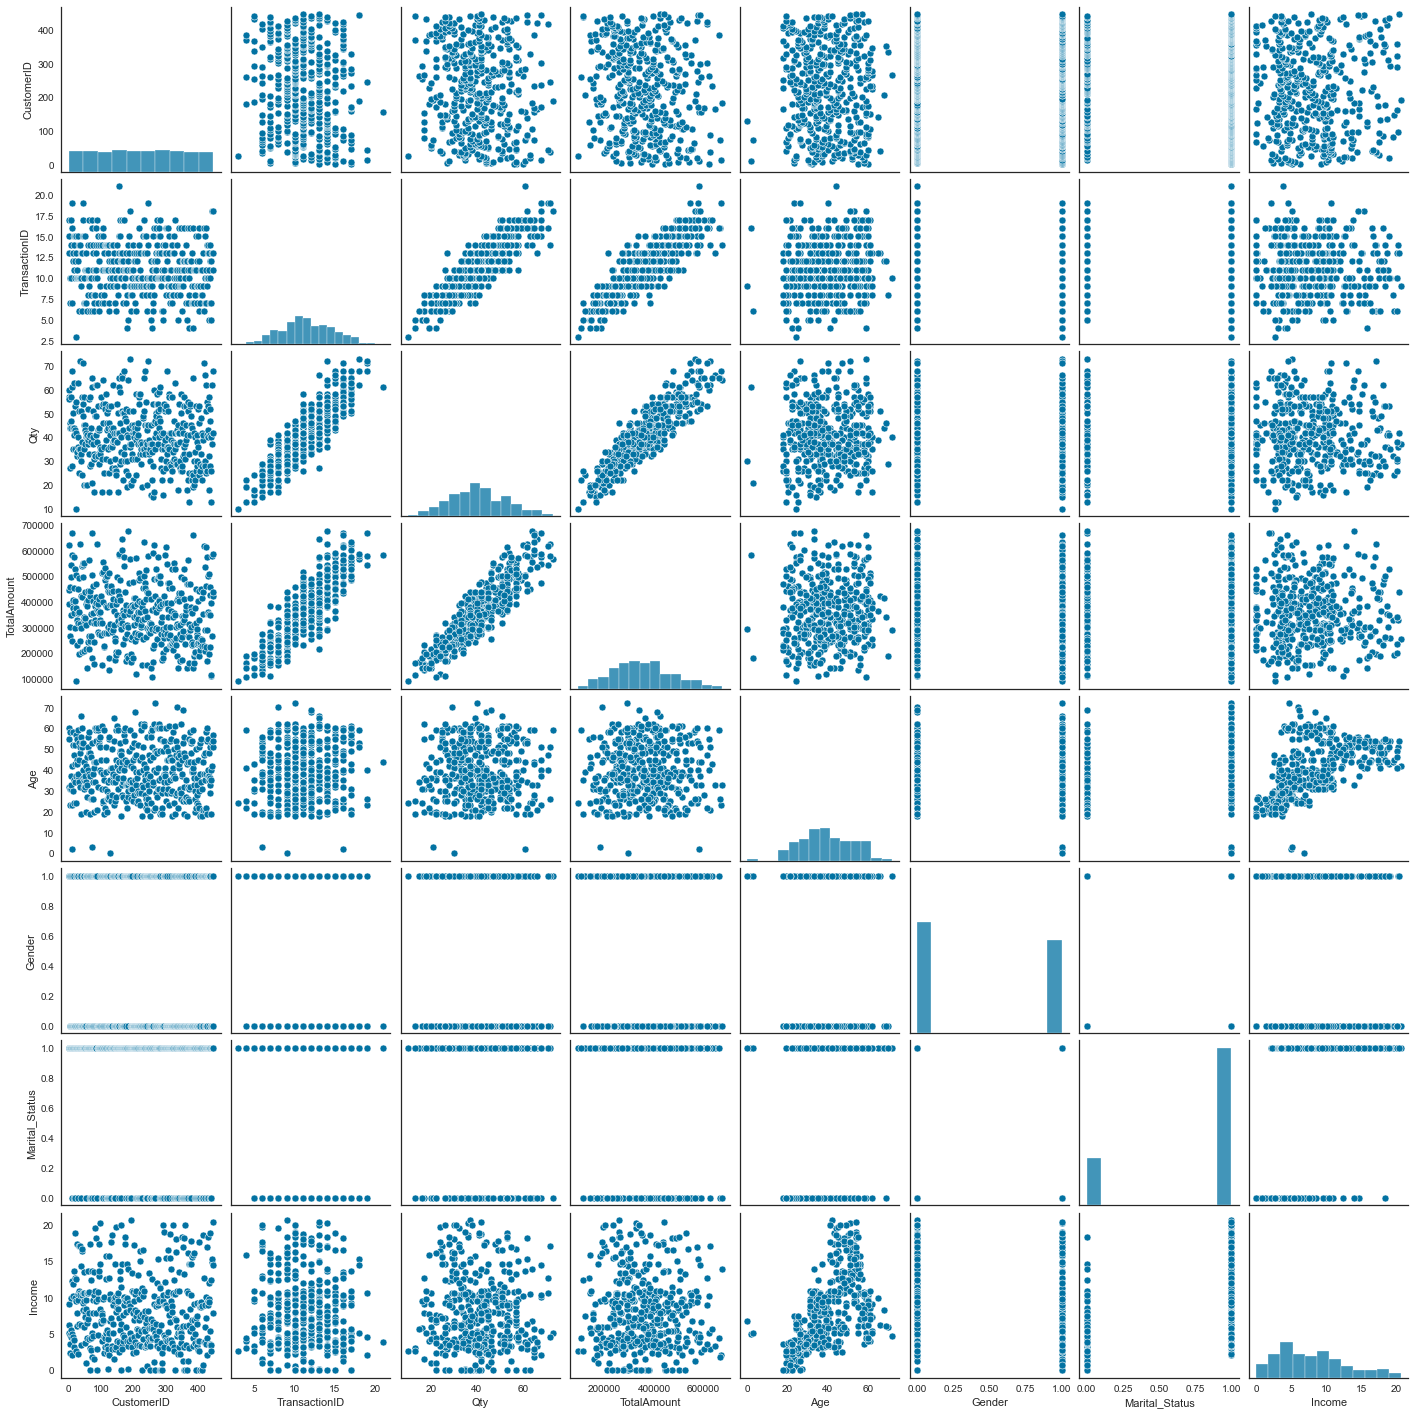

In [35]:
# Finding data relationship using pairplot

sns.pairplot(df_f)

In [44]:
# Removing outliers in Age and Income column

df_merge_f = df_f.copy()
df_merge_f = df_merge_f[(df_merge_f["Age"] > 10)]
df_merge_f = df_merge_f[(df_merge_f["Income"] > 0)]
df_merge_f.reset_index()

,index,CustomerID,TransactionID,Qty,TotalAmount,Age,Gender,Marital_Status,Income
0,0,1,17,60,623300,55,1,1,5.12
1,1,2,13,57,392300,60,1,1,6.23
2,2,3,15,56,446200,32,1,1,9.17
3,3,4,10,46,302500,31,1,1,4.87
4,4,5,7,27,268600,58,1,1,3.57
...,...,...,...,...,...,...,...,...,...
408,439,442,13,37,269400,42,1,1,14.88
409,440,444,18,62,577700,53,0,1,15.31
410,441,445,18,68,587200,51,0,1,14.48
411,442,446,11,42,423300,57,0,1,7.81


In [45]:
df_merge_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 443
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      413 non-null    int64  
 1   TransactionID   413 non-null    int64  
 2   Qty             413 non-null    int64  
 3   TotalAmount     413 non-null    int64  
 4   Age             413 non-null    int64  
 5   Gender          413 non-null    int64  
 6   Marital_Status  413 non-null    int64  
 7   Income          413 non-null    float64
dtypes: float64(1), int64(7)
memory usage: 29.0 KB


Parameters for comparisons
- age and qty
- age and income
- income and qty
- marital status and qty
- gender and qty

Text(0.5, 1.0, 'Income - Total Amount')

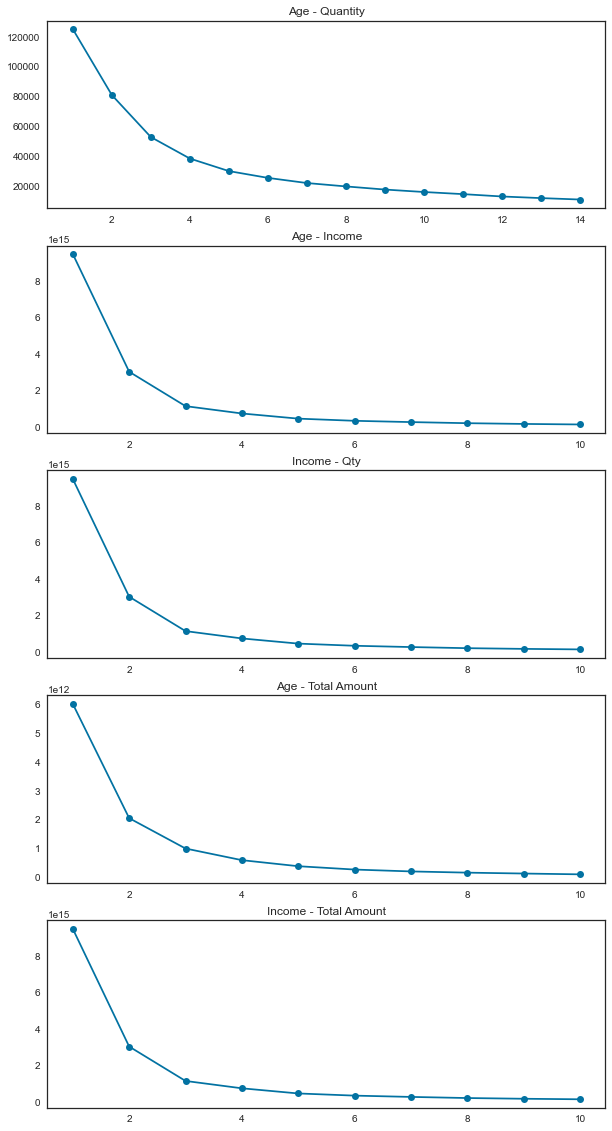

In [64]:
# Elbow method to find the best number of cluster

# Income multiplied by 1000 in order to avoid wrong clustering 
df_merge_f["Income"] = df_merge_f["Income"].multiply(1000)

# Assign each parameters to an array
d1 = df_merge_f[["Age","Qty"]]
d2 = df_merge_f[["Age","Income"]]
d3 = df_merge_f[["Income","Qty"]]
d4 = df_merge_f[["Age","TotalAmount"]]
d5 = df_merge_f[["Income","TotalAmount"]]

# Elbow method
fig, axs = plt.subplots(5, figsize=(10,20))

x = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d1)
    x.append(kmeans.inertia_)
axs[0].plot(range(1,15), x, marker="o")
axs[0].set_title("Age - Quantity")

x2 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d2)
    x2.append(kmeans.inertia_)
axs[1].plot(range(1,11), x2, marker="o")
axs[1].set_title("Age - Income")

x3 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d3)
    x3.append(kmeans.inertia_)
axs[2].plot(range(1,11), x3, marker="o")
axs[2].set_title("Income - Qty")

x4 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d4)
    x4.append(kmeans.inertia_)
axs[3].plot(range(1,11), x4, marker="o")
axs[3].set_title("Age - Total Amount")

x5 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(d5)
    x5.append(kmeans.inertia_)
axs[4].plot(range(1,11), x5, marker="o")
axs[4].set_title("Income - Total Amount")

Possible number of cluster:
- d1 = 4-6
- d2 = 3
- d3 = 3
- d4 = 3
- d5 = 3

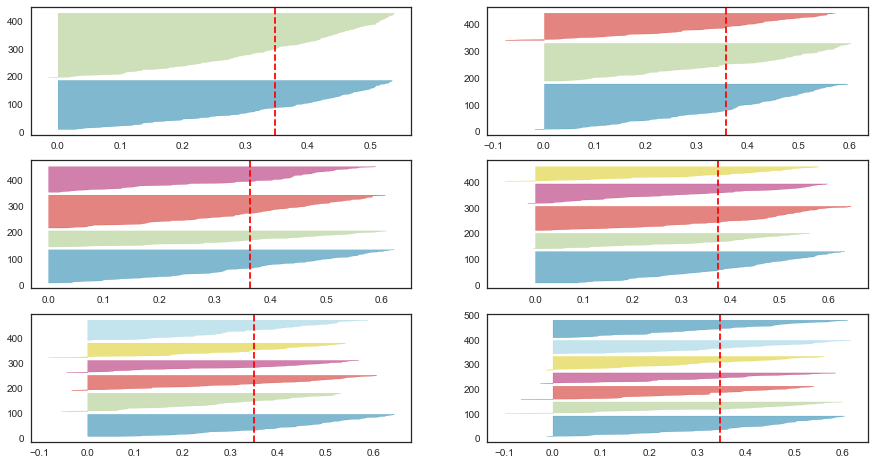

In [65]:
# Silhouete score to further find the best number of cluster

# Silhouete score for Age and Quantity
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in range (2,8):
    km = KMeans(n_clusters=i, init="random", n_init=10)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(d1)
    
# The number of cluster with the least amount of negative silhouete score is K=2 and K=4
# K=2 is to few, hence K=4 is chosen

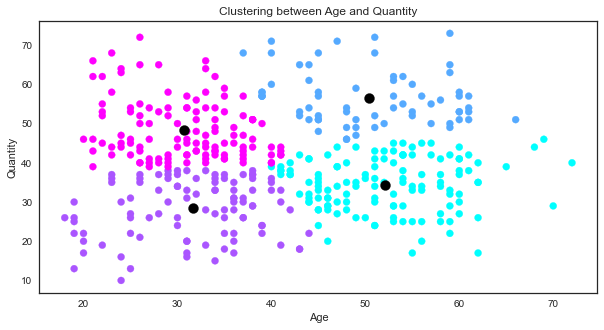

In [66]:
# Plot clustering using KMeans

# KMeans clustering for Age and Quantity
model1 = KMeans(n_clusters=4, init="random", n_init=10)
model1.fit(d1)
labels1 = model1.labels_
centroids1 = model1.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_merge_f["Age"], y=df_merge_f["Qty"], c=labels1, cmap="cool")
plt.scatter(x=centroids1[:,0], y=centroids1[:,1], s=100, c="black")
plt.title("Clustering between Age and Quantity")
plt.xlabel("Age")
plt.ylabel("Quantity")
plt.show()

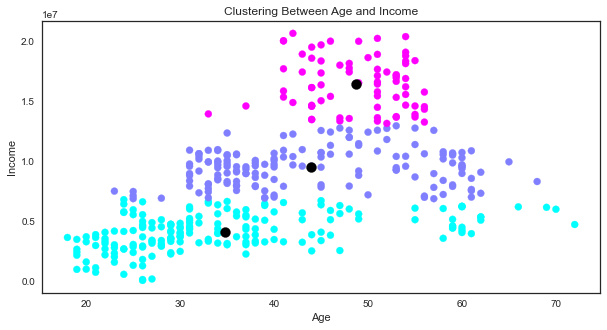

In [67]:
# KMeans clustering for Age and Income
model2 = KMeans(n_clusters=3, init="random", n_init=10)
model2.fit(d2)
labels2 = model2.labels_
centroids2 = model2.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_merge_f["Age"], y=df_merge_f["Income"], c=labels2, cmap="cool")
plt.scatter(x=centroids2[:,0], y=centroids2[:,1], s=100, c="black")
plt.title("Clustering Between Age and Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

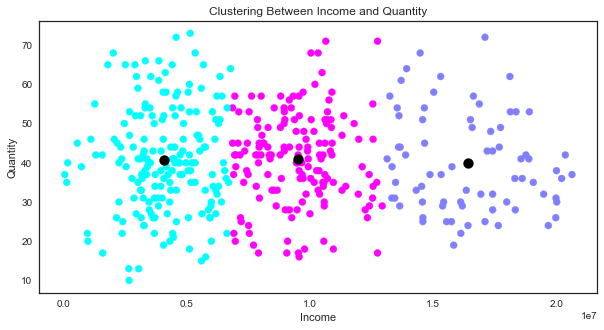

In [71]:
# KMeans clustering for Income and Quantity
model3 = KMeans(n_clusters=3, init="random", n_init=10)
model3.fit(d3)
labels3 = model3.labels_
centroids3 = model3.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_merge_f["Income"], y=df_merge_f["Qty"], c=labels3, cmap="cool")
plt.scatter(x=centroids3[:,0], y=centroids3[:,1], s=100, c="black")
plt.title("Clustering Between Income and Quantity")
plt.xlabel("Income")
plt.ylabel("Quantity")
plt.show()

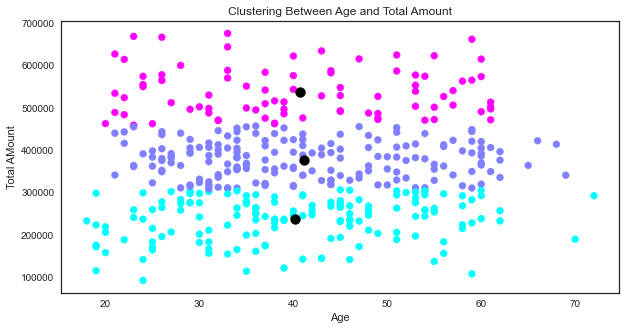

In [80]:
# KMeans clustering for Age and Total Amount
model4 = KMeans(n_clusters=3, init="random", n_init=10)
model4.fit(d4)
labels4 = model4.labels_
centroids4 = model4.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_merge_f["Age"], y=df_merge_f["TotalAmount"], c=labels4, cmap="cool")
plt.scatter(x=centroids4[:,0], y=centroids4[:,1], s=100, c="black")
plt.title("Clustering Between Age and Total Amount")
plt.xlabel("Age")
plt.ylabel("Total AMount")
plt.show()

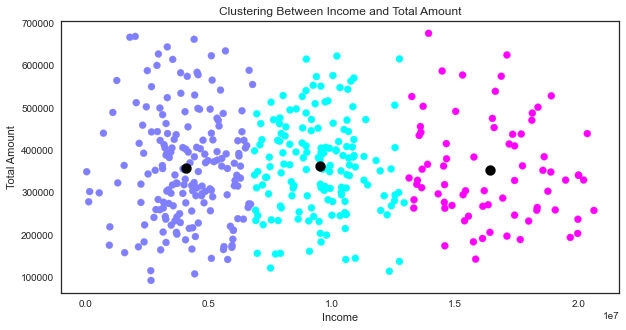

In [79]:
# KMeans clustering for Income and Total Amount
model5 = KMeans(n_clusters=3, init="random", n_init=10)
model5.fit(d5)
labels5 = model5.labels_
centroids5 = model5.cluster_centers_

plt.figure(figsize=(10,5))
sns.set_style("white")
plt.scatter(x=df_merge_f["Income"], y=df_merge_f["TotalAmount"], c=labels5, cmap="cool")
plt.scatter(x=centroids5[:,0], y=centroids5[:,1], s=100, c="black")
plt.title("Clustering Between Income and Total Amount")
plt.xlabel("Income")
plt.ylabel("Total Amount")
plt.show()